# Demo nguyên lý hệ điều hành
Họ và tên: Đào Nhật Minh

MSSV: 20200392

Nội dung demo: Mô phỏng quá trình các phương pháp phân bố file

## Import thư viện

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random
from IPython.display import Video
from matplotlib.animation import Animation, FuncAnimation, FFMpegWriter
from matplotlib.patches import Rectangle, Arrow
from matplotlib.transforms import Bbox

# Tạo các class dùng cho mô phỏng:
1. Block: các khối trong bộ nhớ
2. File: file lưu trữ
3. ContiguousBlock: class con của Block, dùng trong phân bố liên tục
4. ContiguousFile: file lưu bằng phân bố liên tục

In [2]:
class Block:
  def __init__(self) -> None:
    pass
  def setPosition(self, x, y):
    self.x = x
    self.y = y
  def setPatch(self, patch):
    self.patch = patch

class File:
    def __init__(self) -> None:
        pass

class ContiguousBlock(Block):
  def __init__(self, free, label) -> None:
    super().__init__()
    self.free = free
    self.label = label
  def setState(self, free):
    self.free = free

class ContiguousFile(File):
  def __init__(self, name, start, length) -> None:
    super().__init__()
    self.name = name
    self.start = start
    self.length = length
    self.block = []
  def setPatch(self, patch):
    self.patch = patch
  def get(self):
    return [self.name, self.start, self.length]

## Contiguous Allocation
### Hàm khởi tạo & reset 

In [3]:
def resetValue():
    global contiguousBlockWidth 
    contiguousBlockWidth = 4
    global contiguousBlockHeight
    contiguousBlockHeight = 1
    global gap
    gap = 0.5
    global files 
    files = [
        ContiguousFile("File1", 0, 4),
        ContiguousFile("File2", 6, 1),
        ContiguousFile("File3", 14, 6),
        ContiguousFile("File4", 20, 3),
    ]
    global BlocksList
    BlocksList = []

def setViewRange(total_blocks):
    global numberOfBlockPerLine
    numberOfBlockPerLine = 10
    global view_width
    view_width = numberOfBlockPerLine * contiguousBlockWidth + gap * (numberOfBlockPerLine - 1)
    global numberOfLine
    numberOfLine = math.ceil(total_blocks / numberOfBlockPerLine)
    global view_height
    view_height = contiguousBlockHeight * (numberOfLine + 1) + gap * numberOfLine 

Tạo mới 1 thư mục đã lưu sẵn các file

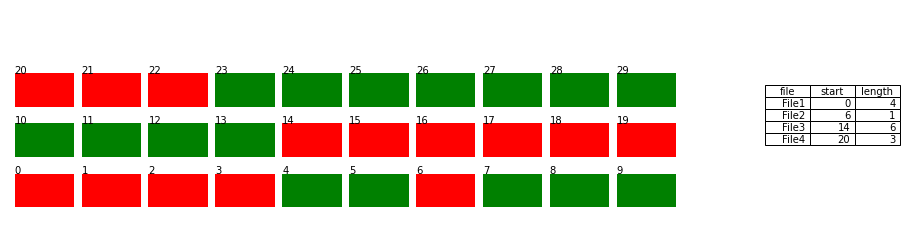

In [4]:
x_position = 0.0
y_position = 0.0
total_blocks = 30
resetValue()
setViewRange(total_blocks)
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 1]}, figsize=(16, 4))
ax1.set_xlim(-gap, view_width + gap)
ax1.set_ylim(-gap, view_height + gap)
ax2.set_ylim(-gap, view_height + gap)
ax1.set_axis_off()
ax2.set_axis_off()
for count in range(total_blocks):
  bl = ContiguousBlock(1, count)
  bl.setPosition(x_position, y_position)
  x_position += contiguousBlockWidth + 0.5
  BlocksList.append(bl)
  if x_position >= view_width:
    y_position += contiguousBlockHeight + 0.5
    x_position = 0.0
  BlocksList[-1].setPatch(Rectangle((bl.x, bl.y), contiguousBlockWidth, contiguousBlockHeight, facecolor="green"))
  ax1.add_patch(BlocksList[-1].patch)
  ax1.text(bl.x, bl.y + contiguousBlockHeight, bl.label)

file_names = []
file_start = []
file_length = []
for file in files:
    for block_id in range(file.start, file.start + file.length):
        BlocksList[block_id].setState(0)
        BlocksList[block_id].patch.set(facecolor = "red")
    data = file.get()
    file_names.append(data[0])
    file_start.append(data[1])
    file_length.append(data[2])
    
df = pd.DataFrame(data={"file": file_names, "start": file_start, "length": file_length})
ax2.table(cellText=df.values, colLabels=df.columns, loc = 'center')

plt.show()

### Mô phỏng quá trình ghi file

*Thao tác chỉ tập trung vào ghi file theo kiểu tuần tự, việc tìm kiếm không gian lưu trữ trống không thuộc phạm vi mô phỏng*

In [5]:
metadata = dict(title='Movie Test', artist='Matplotlib')
writer = FFMpegWriter(fps=3, metadata=metadata)
cnt = 1
new_file_length = [5, 2]
tmp_patch_file = Rectangle((- gap, view_height - contiguousBlockHeight), 
                           (contiguousBlockWidth + gap) * new_file_length[0] + gap, 
                           contiguousBlockHeight + gap, facecolor="gray")
x_position = 0.0
y_position = view_height - contiguousBlockHeight + gap/2
new_block_list = []
ax1.add_patch(tmp_patch_file)
for count in range(10):
    new_block_list.append(ContiguousBlock(1, count))
    new_block_list[-1].setPatch(Rectangle((x_position, y_position), contiguousBlockWidth, 
                                          contiguousBlockHeight, facecolor="yellow"))
    x_position += contiguousBlockWidth + 0.5
    ax1.add_patch(new_block_list[-1].patch)
with writer.saving(fig, "ContiguousAllocation.mp4", 100):
    for len_needed in new_file_length: 
        '''Init'''
        for i in range(len_needed, 10):
            new_block_list[i].patch.set_visible(0)
        
        ''' Find free space '''
        free_length = 0
        free_id = 0
        for i in range(total_blocks):
            if BlocksList[i].free: free_length += 1
            else: free_length = 0
            if free_length == len_needed:
                free_id = i - len_needed + 1
                break
        print(free_id)
        
        ''' Allocation ''' 
        for i in range(len_needed):
            new_block_position = new_block_list[i].patch.get_xy()
            x0 = new_block_position[0] + contiguousBlockWidth / 2
            y0 = new_block_position[1]
            disk_position = BlocksList[free_id + i].patch.get_xy()
            dx = disk_position[0] + contiguousBlockWidth / 2 - x0
            dy = disk_position[1] + contiguousBlockHeight - y0
            tmp_patch_arrow = Arrow(x0, y0, dx, dy)
            ax1.add_patch(tmp_patch_arrow)
            writer.grab_frame()
            BlocksList[free_id + i].setState(0)
            BlocksList[free_id + i].patch.set(facecolor = "red")
            tmp_patch_arrow.remove()
            writer.grab_frame()
        
        ''' Directory '''
        files.append(ContiguousFile("new file" + str(cnt), free_id, len_needed))
        cnt += 1
        df.loc[len(df.index)] = [files[-1].name, free_id, len_needed]
        ax2.table(cellText=df.values, colLabels=df.columns, loc = 'center')
        writer.grab_frame()

7
4


### Kết quả

In [6]:
Video("ContiguousAllocation.mp4", width=980, height=480)